In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

torch.cuda.is_available()

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


True

In [2]:
batch_size_train = 64
batch_size_test = 1000

log_interval = 10

In [3]:
def MNIST():
  MNIST_train = torchvision.datasets.MNIST('/files/', train=True, download=True,
                              transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                  (0.1307,), (0.3081,))
                              ]))
  MNIST_test = torchvision.datasets.MNIST('/files/', train=False, download=True,
                              transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                  (0.1307,), (0.3081,))
                              ]))

  train_loader = torch.utils.data.DataLoader(MNIST_train, batch_size=batch_size_train, shuffle=True)
  test_loader = torch.utils.data.DataLoader(MNIST_test, batch_size=batch_size_test, shuffle=True)
  return train_loader, test_loader

def permute_mnist(mnist, seed):
    """ Given the training set, permute pixels of each img the same way. """

    np.random.seed(seed)
    print("starting permutation...")
    perm_inds = list(range(28*28))
    np.random.shuffle(perm_inds)
    for i in range(len(mnist.data)):
        mnist.data[i] = mnist.data[i].flatten()[perm_inds].reshape(28,28)
    print("done.")

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

class NetNoise(nn.Module):
    def __init__(self):
        super(NetNoise, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(3380, 50)
        self.fc2 = nn.Linear(50, 105)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        print(x.shape)
        # x = x.view(-1, 3380)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

def train(model, optimizer, train_loader, epoch=1):
  train_losses = []
  model.train()
  for e in range(epoch):
      for batch_idx, (data, target) in enumerate(train_loader):
          optimizer.zero_grad()
          output = model(data)
        #   print(output, len(output), type(output))
        #   print(target, len(target), type(target))
        #   break
          loss = F.cross_entropy(output, target)
          loss.backward()
          optimizer.step()
          if batch_idx % log_interval == 0:
              print(f"Epoch {e+1} [{batch_idx * len(data)} / {len(train_loader.dataset)}]       loss: {loss.item()}")
          train_losses.append(loss.item())
  return train_losses

def trainNoise(model, optimizer, train_loader, epoch=1):
  train_losses = []
  model.train()
  for e in range(epoch):
      for batch_idx, (data, target) in enumerate(train_loader):
          optimizer.zero_grad()
          output = model(data)#.argmax(dim=1)
          print(output, len(output), type(output))
          print(target, len(target), type(target))
          print(data.shape)
          loss = F.cross_entropy(output, target)
          loss.backward()
          optimizer.step()
          if batch_idx % log_interval == 0:
              print(f"Epoch {e+1} [{batch_idx * len(data)} / {len(train_loader.dataset)}]       loss: {loss.item()}")
          train_losses.append(loss.item())
  return train_losses

def test(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
      for data, target in test_loader:
          output = model(data)
          test_loss += F.cross_entropy(output, target, size_average=False).item()
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

In [4]:
class L2Norm(nn.Module):
    def forward(self, x):
        return x / x.norm(p=2, dim=1, keepdim=True)


class SmallAlexNet(nn.Module):
    def __init__(self, in_channel=3, feat_dim=128):
        super(SmallAlexNet, self).__init__()

        blocks = []

        # conv_block_1
        blocks.append(nn.Sequential(
            nn.Conv2d(in_channel, 96, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2),
        ))

        # conv_block_2
        blocks.append(nn.Sequential(
            nn.Conv2d(96, 192, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2),
        ))

        # conv_block_3
        blocks.append(nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
        ))

        # conv_block_4
        blocks.append(nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
        ))

        # conv_block_5
        blocks.append(nn.Sequential(
            nn.Conv2d(384, 192, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2),
        ))

        # fc6
        blocks.append(nn.Sequential(
            nn.Flatten(),
            nn.Linear(192 * 7 * 7, 4096, bias=False),  # 256 * 6 * 6 if 224 * 224
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
        ))

        # fc7
        blocks.append(nn.Sequential(
            nn.Linear(4096, 4096, bias=False),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
        ))

        # fc8
        blocks.append(nn.Sequential(
            nn.Linear(4096, feat_dim),
            L2Norm(),
        ))

        self.blocks = nn.ModuleList(blocks)
        self.init_weights_()

    def init_weights_(self):
        def init(m):
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.normal_(m.weight, 0, 0.02)
                if getattr(m, 'bias', None) is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
                if getattr(m, 'weight', None) is not None:
                    nn.init.ones_(m.weight)
                if getattr(m, 'bias', None) is not None:
                    nn.init.zeros_(m.bias)

        self.apply(init)

    def forward(self, x, *, layer_index=-1, average=True):
        if layer_index < 0:
            layer_index += len(self.blocks)
        for layer in self.blocks[:(layer_index + 1)]:
            x = layer(x)

        # NEW: spatial averaging
        if average:
            if x.ndim == 4:
                x = x.mean(dim=-1)
            if x.ndim == 3:
                x = x.mean(dim=-1)

        return x

# Normal learning

Epoch 1 [0 / 60000]       loss: 2.3508710861206055
Epoch 1 [640 / 60000]       loss: 2.2375242710113525
Epoch 1 [1280 / 60000]       loss: 1.887335181236267
Epoch 1 [1920 / 60000]       loss: 1.54896879196167
Epoch 1 [2560 / 60000]       loss: 1.2659269571304321
Epoch 1 [3200 / 60000]       loss: 1.1175657510757446
Epoch 1 [3840 / 60000]       loss: 1.1162062883377075
Epoch 1 [4480 / 60000]       loss: 0.7914644479751587
Epoch 1 [5120 / 60000]       loss: 0.9084195494651794
Epoch 1 [5760 / 60000]       loss: 0.8048217296600342
Epoch 1 [6400 / 60000]       loss: 0.5957791209220886
Epoch 1 [7040 / 60000]       loss: 0.9355965852737427
Epoch 1 [7680 / 60000]       loss: 0.5460583567619324
Epoch 1 [8320 / 60000]       loss: 1.0705218315124512
Epoch 1 [8960 / 60000]       loss: 0.8352608680725098
Epoch 1 [9600 / 60000]       loss: 0.67876797914505
Epoch 1 [10240 / 60000]       loss: 0.6795257925987244
Epoch 1 [10880 / 60000]       loss: 0.6636505126953125
Epoch 1 [11520 / 60000]       loss:

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1030, Accuracy: 9698/10000 (97%)



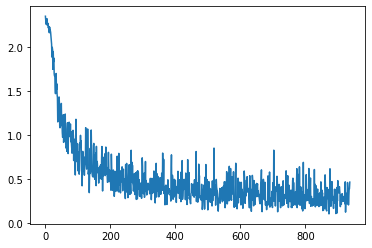

In [5]:
train_loader, test_loader = MNIST()

model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.1)
train_losses = train(model, optimizer, train_loader)
plt.plot(train_losses)
test(model, test_loader)

# Learning Permuted Mnist

starting permutation...
done.
Epoch 1 [0 / 60000]       loss: 2.306448221206665
Epoch 1 [640 / 60000]       loss: 2.300677537918091
Epoch 1 [1280 / 60000]       loss: 2.287625312805176
Epoch 1 [1920 / 60000]       loss: 2.2742397785186768
Epoch 1 [2560 / 60000]       loss: 2.29349946975708
Epoch 1 [3200 / 60000]       loss: 2.259490489959717
Epoch 1 [3840 / 60000]       loss: 2.1945672035217285
Epoch 1 [4480 / 60000]       loss: 2.0362610816955566
Epoch 1 [5120 / 60000]       loss: 2.0229854583740234
Epoch 1 [5760 / 60000]       loss: 1.8488513231277466
Epoch 1 [6400 / 60000]       loss: 1.814603328704834
Epoch 1 [7040 / 60000]       loss: 1.7330471277236938
Epoch 1 [7680 / 60000]       loss: 1.6782238483428955
Epoch 1 [8320 / 60000]       loss: 1.5324171781539917
Epoch 1 [8960 / 60000]       loss: 1.3401588201522827
Epoch 1 [9600 / 60000]       loss: 1.0282862186431885
Epoch 1 [10240 / 60000]       loss: 1.3463170528411865
Epoch 1 [10880 / 60000]       loss: 1.214042067527771
Epoch 1 

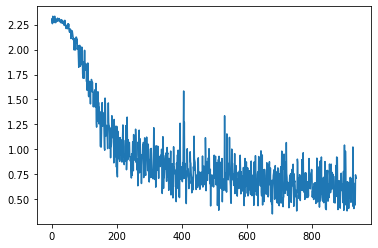

In [6]:
train_loader, test_loader = MNIST()

permute_mnist(train_loader.dataset, 2137)
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.1)
train_losses = train(model, optimizer, train_loader)
plt.plot(train_losses)
test(model, test_loader)

# Pretraining on noise data

In [7]:
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

def dead_leaves_squares():
    imagefolder = "data/dead_leaves-squares/"
    batch_size = 128
    resize_image = True

    class TwoCropsTransform:
        """Take two random crops of one image as the query and key."""

        def __init__(self, base_transform):
            self.base_transform = base_transform

        def __call__(self, x):
            q = self.base_transform(x)
            k = self.base_transform(x)
            return [q, k]

    transform_array = []
    if resize_image:
        transform_array.append(
            torchvision.transforms.Resize((96,96))
        )

    transform_array += [
        torchvision.transforms.RandomResizedCrop(64, scale=(0.08, 1)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
        torchvision.transforms.RandomGrayscale(p=0.2),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.44087801806139126, 0.42790631331699347, 0.3867879370752931),
            (0.26826768628079806, 0.2610450402318512, 0.26866836876860795),
        ),
    ]

    transform = torchvision.transforms.Compose(transform_array)
    # transform = TwoCropsTransform(transform)


    train_path = os.path.join(imagefolder, 'train')
    print(f'Loading data from {imagefolder} as imagefolder')
    dataset = torchvision.datasets.ImageFolder(
        train_path,
        transform=transform)

    val_split = 0.3
    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    train_dataset = Subset(dataset, train_idx).dataset
    test_dataset = Subset(dataset, test_idx).dataset

    # loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True)
    return train_loader, test_loader

In [8]:
train_loader, test_loader = dead_leaves_squares()

model = NetNoise()
optimizer = optim.SGD(model.parameters(), lr=0.1)

train_losses = []
model.train()
for e in range(1):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        print(output, len(output), output.shape)
        print(target, len(target))
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f"Epoch {e+1} [{batch_idx * len(data)} / {len(train_loader.dataset)}]       loss: {loss.item()}")
        train_losses.append(loss.item())

Loading data from data/dead_leaves-squares/ as imagefolder
torch.Size([128, 20, 13, 13])
tensor([[ 0.0726,  0.1129, -0.1317,  ...,  0.1160,  0.2241,  0.0029],
        [ 0.0757,  0.0469, -0.0053,  ...,  0.1138,  0.0797, -0.1267],
        [ 0.1108,  0.0593,  0.0732,  ...,  0.0574, -0.1046,  0.0104],
        ...,
        [ 0.2284, -0.0538,  0.1707,  ..., -0.1034, -0.1015,  0.0314],
        [ 0.0345,  0.1126, -0.0081,  ...,  0.0547,  0.0468, -0.0906],
        [-0.0094,  0.1161,  0.0455,  ...,  0.0998,  0.0535, -0.1215]],
       grad_fn=<AddmmBackward0>) 128 torch.Size([128, 105])
tensor([ 42,  64,  95,  37,  89,  83,  47,   4,  21,  79,  65,  22,  35,  80,
         19,  79,  14,   8,  25,  61,   7,  51,  40,  61,  61,  13,   1,  78,
         23,  42,  95,  67,  34,  26,  59,  92,  93,  47,  32,  15,  80,  31,
         47,   0,  31,  14,  25,  47,  24,  34, 100,   3,  55,  10,   5,  47,
         68,  78,  83,  97,  74,  93,  43,  34,  67,   1,  15,  99,  49,  73,
         84,  19,  71,  96,

In [9]:
1352/104

13.0

In [10]:
train_loader, test_loader = dead_leaves_squares()

model = NetNoise()
optimizer = optim.SGD(model.parameters(), lr=0.1)
train_losses = trainNoise(model, optimizer, train_loader)
# plt.plot(train_loader)
# test(model, test_loader)

Loading data from data/dead_leaves-squares/ as imagefolder
torch.Size([128, 20, 13, 13])
tensor([[ 0.0621, -0.1182,  0.0643,  ...,  0.0523,  0.0864,  0.0124],
        [ 0.0474, -0.2018,  0.0423,  ..., -0.0795,  0.0693,  0.0398],
        [-0.0646, -0.0832,  0.0441,  ..., -0.0199,  0.1078, -0.0522],
        ...,
        [-0.0073, -0.0600, -0.0782,  ...,  0.2574,  0.0475, -0.1436],
        [ 0.0230, -0.0711,  0.0085,  ...,  0.0528,  0.0570,  0.0572],
        [ 0.1272, -0.1255,  0.1067,  ...,  0.0639,  0.0494, -0.0535]],
       grad_fn=<AddmmBackward0>) 128 <class 'torch.Tensor'>
tensor([ 35,  75,  94,  48,  20,  28,  62,  62,  25,  52,  61,  77,  10,  82,
         27,   4,  52,  91,  65,  70,   3,  22,  16,   9,  16,  42,  98, 104,
         43,  36,  49,  10,  60, 103,  84, 102,  42,  71,  94,  59,  65,  85,
         87,  34,  21,  90,  86,  88,  65,  98,   6,  97,  81,  42,  53,  44,
         72,  43,  55,  75,  16,  91,  26,  39,  93,  85,  83,  80,  45,  43,
         21,  95,  37,  49,

KeyboardInterrupt: 

In [11]:
train_loader, test_loader = dead_leaves_squares()

model = SmallAlexNet()
optimizer = optim.SGD(model.parameters(), lr=0.1)
train_losses = trainNoise(model, optimizer, train_loader)

Loading data from data/dead_leaves-squares/ as imagefolder
tensor([[-0.2221,  0.0403,  0.1236,  ...,  0.1130,  0.1243, -0.0729],
        [-0.0832, -0.0450,  0.0707,  ...,  0.1159, -0.0634, -0.0960],
        [-0.1911, -0.0829, -0.0245,  ..., -0.0853,  0.0799, -0.0489],
        ...,
        [-0.2607,  0.0321,  0.1721,  ..., -0.0461,  0.0229, -0.0339],
        [-0.2054, -0.1340, -0.0217,  ..., -0.0574, -0.0690,  0.1035],
        [-0.1420, -0.0681,  0.0622,  ...,  0.1842,  0.0512,  0.0197]],
       grad_fn=<DivBackward0>) 128 <class 'torch.Tensor'>
tensor([ 86,  76,  87,  49,  74,  78,  38,  53,  54,  24,  99,  21,  73,  62,
         37,  91,  63, 104, 103,  21,   6,  40,  80,  14,  25,  91,  62,  77,
          5,  90,  81,  42,  66,  54,  84,  22,  41,  66,  87,  27,  33,   9,
         87,  47,   8, 103,  20,  90, 100,  35, 101,  37, 100,  53,  87,  45,
          8,   1,  74,  55,  48,  90,  62,  94,  42,  37,  37,  86,  97,   6,
         72,   2,  22,  40,  47,  29,  48,   7,  38,  71,  

KeyboardInterrupt: 

In [12]:
train_loader, test_loader = dead_leaves_squares()

model = SmallAlexNet()
optimizer = optim.SGD(model.parameters(), lr=0.1)
train_losses = train(model, optimizer, train_loader)

Loading data from data/dead_leaves-squares/ as imagefolder
Epoch 1 [0 / 105000]       loss: 4.876524925231934
Epoch 1 [1280 / 105000]       loss: 4.850579738616943


KeyboardInterrupt: 

# freeze and train on MNIST

In [13]:
model.conv1.requires_grad_(False)
model.conv2.requires_grad_(False)
model.conv2_drop.requires_grad_(False)
model.fc1.requires_grad_(False)
model.fc2.requires_grad_(False)

AttributeError: 'SmallAlexNet' object has no attribute 'conv1'